***Indexing Laue pattern of several images using multiprocessing***

on jupyter-slurm.esrf.fr (jupyterlab or jupyterhub)

or

locally on desktop computer (with some cpus) and with access to the LaueTools environment or folder

**IN DEV**

**This Notebook is a part of the LaueTools Package** 
Author: J.-S. Micha

Last Revision:   March 2025

tested with python 3.8  on jupyterlab and jupyter hub, jupyter-notebook

**Objectives**

- 1 image

-- Index from scratch and Refine Strain

-- Check orientation and Refine Strain (followed or not by indexing from scratch), use previous results (1 or n orientation matrix)

-- [TO COME] Handle multiphase (substrate case) or multigrains indexing

- N images

-- Use previous results (DB orientation matrix, propagation)

-- [TO COME] Select subset of sample point

-- [TO COME] Track, Select, Blacklist Spots

The main goal of indexing is to:

- identify hkl Miller indices of Laue spots
- identify phase material of Laue spots (grain)

As a results:

- .fit files are generated (all indexed spots properties list )
- ####_g0.fit, ####_g1.fit, ... generated (indexed spots properties list per grain)


# SET runtime jupyterlab or not

In [1]:
JUPYTER_LAB = True # False for jupyter hub or notebook
ON_LINUX = True
# just to have a trace of current dependencies version if problems
# if ON_LINUX:
#     !jupyter --version

# IMPORTS

In [2]:
import multiprocessing
nbmaxcpus = multiprocessing.cpu_count()
print(f'nb of cpus available: {nbmaxcpus}')

nb of cpus available: 64


In [3]:
# if logged in jupyter-slurm.esrf.fr, please select the kernel LAUETOOLSENV2
# in Kernel top bar menu  /Kernel/ change Kernel

In [4]:
# use Lauetools installed in an environnement (with pip or conda) is recommended
import os, sys
import pickle
import datetime
import LaueTools as LT
LaueToolsCode_Folder = os.path.split(LT.__file__)[0]
print('absolute path of LaueTools package',LaueToolsCode_Folder)
print("\nIf you are on jupyter-slurm, you should see: <module 'LaueTools' from '.../.../bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools/__init__.py'>")
LT

absolute path of LaueTools package /mnt/multipath-shares/data/bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools

If you are on jupyter-slurm, you should see: <module 'LaueTools' from '.../.../bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools/__init__.py'>


<module 'LaueTools' from '/mnt/multipath-shares/data/bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools/__init__.py'>

In [5]:
#OR use your own lauetools.
# Setting absolute path to LaueTools Modules folder (containing __iniy__.py) if Lauetools has not been installed with pip
if 0:
    LaueToolsCode_Folder = '/my/path/to/lauetools/'
    import sys
    sys.path.append(LaueToolsCode_Folder)
    print(sys.path)

In [6]:
if not JUPYTER_LAB:
    %matplotlib notebook  # jupyterhub
else:
    %matplotlib widget 

import time,copy,os

# Third party modules
import matplotlib as mpl     # graphs and plots
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

from tqdm import tqdm, tqdm_notebook
import multiprocessing
from multiprocessing import active_children, cpu_count
import itertools

# LaueTools modules
import LaueTools.readmccd as RMCCD
#import LaueTools.LaueGeometry as F2TC
import LaueTools.indexingSpotsSet as ISS
import LaueTools.IOLaueTools as IOLT
import LaueTools.generaltools as GT
import LaueTools.dict_LaueTools as DictLT

-- WARNING: Missing library libtiff, Please install: pylibtiff if you need open some tiff images. However, Fabio or PIL can do the job!
-- warning: sklearn.metrics is not installed. For matchingrate.py module, it could be useful... but not necessary
-- WARNING: module Image or PIL is not installed, but only used for templateimagematching


# SET user scan measurements inputs

**folder of .cor files, 2D map dimensions, Laue detector type ... **

In [7]:
from pathlib import Path
INDEX_COR_FILES_IN_FOLDER = True

if INDEX_COR_FILES_IN_FOLDER:
    
    # parent folder of all dataset data (from .cor files coming from peaksearch results on images)
    maindatafolder = '/data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA'
    # subfolder where images .tiff are
    subfolderscandata = 'sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001'
    
    datfilefolder = Path(maindatafolder+'/'+subfolderscandata+'//'+'datfiles_notebook')
    corfilefolder = datfilefolder
    
    prefixfilename= 'img_'
    suffix='.cor'
    CCDLabel = 'sCMOS'
    sizeofzeropadding = 4  # means myprefix_0023.tif  myprefix_9253.tif  myprefix_65253.tif
    
    # calibration parameters file
    detfile = Path(maindatafolder+'/'+'sample1_test/sample1_test_Ge_20240628/scan0001/Ge111calib_28june2024.det')
    
    # map dimensions
    # they can be found from BLISS command
    # dmesh motor1 value value nbsteps1 motor2 value value nbsteps2 exposure_time
    # so mapdims = (nbsteps motor2 + 1, nbsteps motor1 + 1) = (slow motor, fast motor)
    mapdims = (41,41)
    
    if not Path(maindatafolder+'/'+subfolderscandata).exists():
        raise ValueError(f'The folder {Path(maindatafolder+"/"+subfolderscandata)} does not exists!')
    
    # -----------------automatically generated folder ---------------------------------
    imagefolder = Path(maindatafolder+'/'+subfolderscandata)

    fitfilefolder = Path(maindatafolder+'/'+subfolderscandata+'//'+'fitfiles_notebook')
    
    if not fitfilefolder.exists():
        print('Creating "fitfilefolder" ...')
        Path.mkdir(fitfilefolder)
        
    corfilefolder = datfilefolder
    
    #outputfolder = '/data/visitor/blc14894/bm32/20231007/NOBACKUP/'
    
    print('images folder:  \n    =====> %s'%imagefolder)
    print('.fit files will be written in this folder: \n    =====> %s'%fitfilefolder)

images folder:  
    =====> /data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001
.fit files will be written in this folder: 
    =====> /data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/fitfiles_notebook


In [8]:
#!cat {os.path.join(corfilefolder,'img_%04d.cor'%imageindex)}

In [9]:
#!ls {fitfilefolder}

In [10]:
#!cat {str(corfilefolder)+'/img_0547_g0.fit'}

# [OPTIONAL] SET new Material (Crystallographic unit cell) for indexing

set `mymaterials`= None if you want to use LaueTools default dict of materials

In [11]:
key_material = 'Zn'

if key_material not in DictLT.dict_Materials.keys():
    msg = f'{key_material} is unknown!\nPlease add your own materials as a dict as in the following:\n '
    msg += '  mymat={"mykey":["mykey", [2,2,2,90,90,120],"no"]}\nwhich should contain '
    msg += '"mykey", a list of lattice parameters and a key for the extinction rules. \n'
    msg += 'See dict_LaueTools and CrystalParameters modules'
    GT.printred(msg)
    
searchedstring = 'Zn'
print(f'\n-------List of key_material containing "{searchedstring}" in the default dictionary-------------------')
print("\n".join([f"'{key}': {DictLT.dict_Materials[key]}," for key in DictLT.dict_Materials.keys() if searchedstring in key]))


#print(f'\n-------List of extinction rules -------------------')
#print("\n".join([str(it) for it in DictLT.dict_Extinc_inv.items()]))

mymaterials = None  # use default LaueTools Dict

# mymaterials = {'CuZnAl_betabrass': ['CuZnAl_betabrass', [4.4, 5.3, 3.8, 90, 88, 90], 'no'],
# 'CuZnAl_betabrass_light': ['CuZnAl_betabrass_light', [4.4, 5.3, 3.8, 90, 88, 90], 'VO2_mono'],
# 'CuZnAl_tetra': ['CuZnAl_tetra', [4.1, 4.1, 5.8, 90, 90, 90], 'no'],
# 'CuZnAl_6M1': ['CuZnAl_6M1', [4.5, 5.45, 1.3, 94.2, 90, 90], 'no'],
# 'Zn': ['Zn', [2.6649, 2.6649, 4.9468, 90, 90, 120], 'wurtzite'],
# 'ZnO': ['ZnO', [3.252, 3.252, 5.213, 90, 90, 120], 'wurtzite'],
# 'ZnCuOCl': ['ZnCuOCl', [6.839, 6.839, 14.08, 90.0, 90, 120.0], 'SG166'],
# 'ZnCuOCl_all': ['ZnCuOCl_all', [6.839, 6.839, 14.08, 90.0, 90, 120.0], 'no'],}


-------List of key_material containing "Zn" in the default dictionary-------------------
'CuZnAl_betabrass': ['CuZnAl_betabrass', [4.4, 5.3, 3.8, 90, 88, 90], 'no'],
'CuZnAl_betabrass_light': ['CuZnAl_betabrass_light', [4.4, 5.3, 3.8, 90, 88, 90], 'VO2_mono'],
'CuZnAl_tetra': ['CuZnAl_tetra', [4.1, 4.1, 5.8, 90, 90, 90], 'no'],
'CuZnAl_6M1': ['CuZnAl_6M1', [4.5, 5.45, 1.3, 94.2, 90, 90], 'no'],
'Zn': ['Zn', [2.6649, 2.6649, 4.9468, 90, 90, 120], 'wurtzite'],
'ZnO': ['ZnO', [3.252, 3.252, 5.213, 90, 90, 120], 'wurtzite'],
'ZnCuOCl': ['ZnCuOCl', [6.839, 6.839, 14.08, 90.0, 90, 120.0], 'SG166'],
'ZnCuOCl_all': ['ZnCuOCl_all', [6.839, 6.839, 14.08, 90.0, 90, 120.0], 'no'],


## [OPTION] set your own materials

In [12]:
if 0:
    # you may need to prepare your own materials dictionary containing only 'key_material' if 'key_material' is not in the default dictionary
    mymaterials = {'CuZnAl_betabrass': ['CuZnAl_betabrass', [4.4, 5.3, 3.8, 90, 88, 90], 'no'],
                  'ZnO': ['ZnO', [3.252, 3.252, 5.213, 90, 90, 120], 'wurtzite'],
                  'Zn': ['Zn', [2.6649, 2.6649, 4.9468, 90, 90, 120], 'wurtzite']}

    # OR in a parametric way
    c0 = 4.85
    mymaterials = {}
    for kk in range(10):
        mymaterials['Zn%d'%kk]= ['Zn%d'%kk, [2.6649, 2.6649, c0+0.03*kk, 90, 90, 120], 'wurtzite']

    


In [13]:
if mymaterials is not None:
    print('\n-------- mymaterials  dict --------------')
    print(mymaterials)
else:
    print('Using default dict of materials and should contain your "key_material" label')

Using default dict of materials and should contain your "key_material" label


## [OPTIONAL] SET some matrices coming from previous or current analyses

In [14]:
# Guessed UB matrix (example)
UB_1 = np.array([[ 0.800890339,  0.111020812,  0.588618058],
       [ 0.006589284, -0.983840123,  0.176252946],
       [ 0.59871938 , -0.137579654, -0.788529267]])

UB_2 = np.array([[-0.944886962989832, -0.16481648329929 ,  0.282364299451425],
       [ 0.325288903402363, -0.401682702128187,  0.855560084566674],
       [-0.027898445634874,  0.899571897959609,  0.434481129960923]])

UB_3 = np.array([[ 0.798694755,  0.111538191,  0.591397078],
       [ 0.005701942, -0.983734667,  0.177867478],
       [ 0.601654241, -0.138824412, -0.786302534]])

UB_4 = np.array([[-0.944887005, -0.164816017,  0.282364339],
       [ 0.325288815, -0.401682583,  0.855559726],
       [-0.027898058,  0.899571114,  0.434480798]])

UB_5 = np.array([[ 0.790931358,  0.04942662 ,  0.610343974],
       [ 0.006278407, -0.99719131 ,  0.072531087],
       [ 0.611965387, -0.053681208, -0.788581226]])

UB_6 = np.array([[ 0.790951967,  0.049463864,  0.610128265],
       [ 0.006315838, -0.997021885,  0.072650861],
       [ 0.611938365, -0.053678736, -0.788500541]])

# [OPTIONAL] test of refinement only from a proposed UB matrix on a dataset from 1 image

In [15]:
imageindex = 547

key_material ='Zn'
e_min = 5
e_max = 27 # for refinement
emax_MR = 18 # for indexing step only
previousResults = (2, [UB_2, UB_1], 0, 0)

# Index refine parameters
dict_indexrefine = {# spots set A:  [0,2,58,34] CAUTION max(A) < NBMAXPROBED
                    'central spots indices': [0,1,2],
                    'AngleTolLUT': 0.1,   # Tolerance angle [deg] to recognise angles in the Angular LUT Database
                    'nlutmax': 4,         # Maximum miller index in the Angular LUT Database
                    #number of most intense spot candidate to have a recognisable distance
                    'NBMAXPROBED': 5, # spots set B alias of [0, ..., NBMAXPROBED-1]
                    'MATCHINGRATE_ANGLE_TOL': 0.3,
                    'MinimumMatchingRate': 0,  # minimum MR to accept a previousresults matrix for further refinement
                    'MinimumNumberMatches': 20,  # minimum absolute number of matches (laue spots) keep in list of potential UB
                    'CheckOrientation': None, # os.path.join(working_dir,'UBmat.ubs'),
                    'MATCHINGRATE_THRESHOLD_IAL': 2,  #
                    'GuessedUBMatrix': None,
                    # During Refinement steps: Angular tolerance list for auto links between exp. - theo. spots
                    'list matching tol angles': [0.5,0.2,0.1],#,0.1], 
                    'UseIntensityWeights': False,
                    'nbSpotsToIndex': 10000, # during refinement max number of pairs exp.-theo. spots
                    }

# list of minimum matching rates that accept to perform the next refinement step (with less tolerance angle)
# Last term is the final minimum matching rate (in percent) to accept the final refinement.
MatchingRate_List = [2]*len(dict_indexrefine['list matching tol angles'])
# len(MatchingRate_List) > len('list matching tol angles')

# ---------------end of user parameters----------------------------------------
pathfilecor = os.path.join(corfilefolder,'img_%04d.cor'%imageindex)



t0 = time.time()
# (Re)Initialize object spotsset
dataset = ISS.spotsset()

# Init the dataset with laue spots of .cor file
info = dataset.importdatafromfile(pathfilecor, verbose=0)
print('import dataset from .cor file',info)

# missing info from the dictionary filled manually
dataset.key_material = key_material
dataset.emin = e_min
dataset.emax = e_max
dataset.emax_MR = emax_MR

# index the current dataset
dataset.IndexSpotsSet(None,key_material,e_min,dataset.emax,dict_indexrefine,None,
                              use_file=0, # if 1 , reinit dataset and first argument must be a path to .cor file
                              IMM=False,
                              n_LUT = dict_indexrefine['nlutmax'],
                              LUT = None,
                              angletol_list = dict_indexrefine['list matching tol angles'],
                              nbGrainstoFind = 1, 
                              previousResults = previousResults,
                              dirnameout_fitfile = fitfilefolder,
                              corfilename = pathfilecor,
                              verbose = 0,
                              MatchingRate_List = MatchingRate_List,
                             dictmaterials = mymaterials,
                     choose_UB_MinEulerepresentative=False)

#dataset.dict_grain_devstrain, dataset.dict_grain_latticeparameters, dataset.key_material, dataset.dict_grain_matching_rate

print(f'---- Results of indexing image #{imageindex} ----')
if previousResults:
    print('Starting first by checking previousResults: \n', previousResults, '\n')
print("-------- initial nb of spots",dataset.nbspots)
print("dict of UB matrix found",dataset.dict_grain_matrix)
print('dict of nb of indexed spots and matching rate (%):',dataset.dict_grain_matching_rate)

print(f'For energy max {dataset.emax} keV, dict of nb of indexed spots and matching rate (%):',dataset.dict_grain_matching_rate)
pixelresidues = dataset.pixelresidues
if pixelresidues is not None:
    meanpixdev = np.mean(pixelresidues)
    GT.printgreen(f'For energy max {dataset.emax} keV, nb of spots for refinements : {len(pixelresidues)}')
    GT.printgreen(f'Mean pixel residue {meanpixdev:.2f} pixel') 
if dataset.dict_grain_matrix is {} or any([v is None for v in dataset.dict_grain_matrix.values()]):
    GT.printred('... Nothing found ...')
print(f'\nElapsed time {time.time()-t0:.2f} sec  with internal multiprocessing of {nbmaxcpus} cpus')

import dataset from .cor file no warning
---- Results of indexing image #547 ----
Starting first by checking previousResults: 
 (2, [array([[-0.944886962989832, -0.16481648329929 ,  0.282364299451425],
       [ 0.325288903402363, -0.401682702128187,  0.855560084566674],
       [-0.027898445634874,  0.899571897959609,  0.434481129960923]]), array([[ 0.800890339,  0.111020812,  0.588618058],
       [ 0.006589284, -0.983840123,  0.176252946],
       [ 0.59871938 , -0.137579654, -0.788529267]])], 0, 0) 

-------- initial nb of spots 263
dict of UB matrix found {0: array([[-0.944832876544831, -0.165085716175644,  0.282825185198549],
       [ 0.325444138867466, -0.401946165517163,  0.855790331077727],
       [-0.027919789586167,  0.89970254271565 ,  0.434230265985471]])}
dict of nb of indexed spots and matching rate (%): {0: [67, 38.06818181818182]}
For energy max 27 keV, dict of nb of indexed spots and matching rate (%): {0: [67, 38.06818181818182]}
For energy max 27 keV, nb of spots for re

# INDEX & REFINE (Multiprocessing) of multiple .cor files

**write as many img_####_g0.fit from img_####.cor file if strain refinement quality is satisfactory**

## SET elementary function (single cpu computation) with user-defined parameters

In [24]:
# General parameters indexation
e_min = 5   # [keV]
e_max = 27  # [keV]  for strain refinement
e_max_MR = 18  # [keV] for Matching rate during indexing step
key_material = 'Zn'

nbGrainstoFind = 1

verboselevel = 0

depth = 0  # microns (normal to surface sample)

# Index refine parameters
dict_indexrefine = {# spots set A:  [0,2,58,34] CAUTION max(A) < NBMAXPROBED
                    'central spots indices': [0,1,2],
                    'AngleTolLUT': 0.1,   # Tolerance angle [deg] to recognise angles in the Angular LUT Database
                    'nlutmax': 4,         # Maximum miller index in the Angular LUT Database
                    #number of most intense spot candidate to have a recognisable distance
                    'NBMAXPROBED': 5, # spots set B alias of [0, ..., NBMAXPROBED-1]
                    'MATCHINGRATE_ANGLE_TOL': 0.3,
                    'MinimumMatchingRate': 0,  # minimum MR to accept a previousresults matrix for further refinement
                    'MinimumNumberMatches': 20,  # minimum absolute number of matches (laue spots) keep in list of potential UB
                    'CheckOrientation': None, # os.path.join(working_dir,'UBmat.ubs'),
                    'MATCHINGRATE_THRESHOLD_IAL': 2,  #
                    'GuessedUBMatrix': None,
                    # During Refinement steps: Angular tolerance list for auto links between exp. - theo. spots
                    'list matching tol angles': [0.5,0.2,0.1],#,0.1], 
                    'UseIntensityWeights': False,
                    'nbSpotsToIndex': 10000, # during refinement max number of pairs exp.-theo. spots
                    }

# list of minimum matching rates that accept to perform the next refinement step (with less tolerance angle)
# Last term is the final minimum matching rate (in percent) to accept the final refinement.
MatchingRate_List = [2]*len(dict_indexrefine['list matching tol angles'])
# len(MatchingRate_List) > len('list matching tol angles')

# TO AVOID LOW INFORMATION DATA   or COMPLICATED DATA
MIN_NUMBERSPOTS_FOR_INDEXING = 6
MAX_NUMBERSPOTS_FOR_INDEXING = 10000



#-----------------------------------------------------------------------------
# Elementary function to iterate over for serialization
def index_refine(filename, ignorefitfileresults=True, usepreviousUB=False,
                 skipindexing=True, useinternalmultiprocessing=True, writefitfile=True,
                 verboselevel=0):
    """
    index and refine Laue spots position a .cor file.
    
    According to `ignorefitfile`, the analysis of the .cor file can be omitted
                if previous results written in a corresponding .fit file already exists 
    
    Indexing from scratch step can be skipped by inputing orientation matrix(ces) from previous results
    
    
    ignorefitfileresults: bool, 
        True, the dataset with be analysed (or reananalysed) whatever the existence of previous results
                in corresponding .fit files (existing fit files will be updated and overwritten).
        False, consider only .cor file without any previous results written in the corresponding .fit file.
                Dataset in .cor with already existing results in .fit file won't be (re)analysed
                    T
    usepreviousUB: 'fromfitfile' UB matrix from previous results written in corresponding .fit file will be used
                            for refinement for the currrent dataset in .cor file. If refinment is not successful,
                            then indexing from scratch is started.
                    4 elements tuple: (nb matrices, list of 3x3 matrice, _ ,_) prev to test UB matrix or matrices for successful refinement
                    before finally indexing from scratch if not successful.
                    False: indexing from scratch directly
                    
    skipindexing: bool, after poor refinement of previous UB results, indexing from scratch is inhibited. This a check and refine orientation mode
    
    useinternalmultiprocessing: True when calling this function and acceleration with mpi, False when calling it and process wiht 1 cpu

    writefitfile: bool, write results .fit file, if refinement results are satisfactory
    
    global variables defined above:
    filecor_temp
    fitfilefolder
    dict_indexrefine  with its parameters
    previousResults
    key_material
    e_min
    e_max
    nbGrainstoFind
    verboselevel
    MIN_NUMBERSPOTS_FOR_INDEXING
    MAX_NUMBERSPOTS_FOR_INDEXING
    MatchingRate_List
    """
    if isinstance(filename, str):
        filename = Path(filename)
    
    filecor_temp = filename.name
    image_index = GT.getfileindex(filecor_temp)

    if not Path(filename).exists():
        return [image_index, [],[], 'missing .cor file']
                    
    dataset_temp = ISS.spotsset()
    dataset_temp.useinternalmultiprocessing = useinternalmultiprocessing
    info = dataset_temp.importdatafromfile(filename, verbose=verboselevel)
    #print(flag)
    
    if 'empty' in info:
        return [0, [],[], '.cor file is empty!']
    
    dataset_temp.key_material = key_material
    dataset_temp.emin = e_min
    dataset_temp.emax = e_max
    dataset_temp.emax_MR = e_max_MR
    
    if dataset_temp.nbspots < MIN_NUMBERSPOTS_FOR_INDEXING and dataset_temp.nbspots > MAX_NUMBERSPOTS_FOR_INDEXING:
        return [dataset_temp.nbspots, [],[], 'to few or too many spots to index']
    
    previousResults = None
    relatedfitfile = Path(fitfilefolder)/(filecor_temp[:-4]+'_g0.fit')
    info =''
    if not ignorefitfileresults:
        if relatedfitfile.exists():
            return [image_index, [],[], 'not reanalyzed']
        else:
            info='.fit file was missing. '
                
                
    if usepreviousUB == 'fromfitfile':
        if relatedfitfile.exists():
            # read matrix from fit file
            # set previousResults so to skip indexing and go directly to refinement step
            
            #print('read matrix and etc... to be implemented %s'%relatedfitfile)
            UB_g0 = IOLT.readfitfile_multigrains(relatedfitfile)[3].reshape((3,3))
            #print(UB_g0)
            previousResults = (1, [np.array(UB_g0)], 0, 0)

            info = 'Tried UB matrix from .fit file. '

        else:
            info = 'Could not try UB matrix because .fit file was missing. '
    elif usepreviousUB is False:
        pass
    elif isinstance(usepreviousUB, (list, tuple)):
        previousResults = usepreviousUB
    else:
        raise ValueError("%s should be in [False, 4 elemts tuple, 'fromfitfile']"%usepreviousUB)
                

    if skipindexing and usepreviousUB:
        dataset_temp.inhibitindexing = True
        info += ' Check orientation and refine only (no indexing from scratch).'
    dataset_temp.IndexSpotsSet(None,
                               key_material,
                               e_min,
                               dataset_temp.emax,
                               dict_indexrefine,
                               None,
                               use_file=0,
                               IMM = False,
                               n_LUT = dict_indexrefine['nlutmax'],
                               LUT = None,
                               angletol_list = dict_indexrefine['list matching tol angles'],
                               nbGrainstoFind = nbGrainstoFind, 
                               previousResults = previousResults,
                               dirnameout_fitfile = fitfilefolder,
                               corfilename = filecor_temp,
                               verbose = verboselevel,
                               MatchingRate_List = MatchingRate_List,
                               depth=depth,
                              dictmaterials = mymaterials,
                              writefitfile=writefitfile)
                      
    info+=' Treated by IndexSpotsSet().'
    
    return [image_index,
        [(key, value) for key, value in (dataset_temp.dict_grain_matrix).items()],  # UB matrix
        [(key, value) for key, value in (dataset_temp.dict_grain_matching_rate).items()], # Nb spots indexed and Matching Rate
       info] 
 

In [25]:
### [LOOK] at some dataset in a .cor file

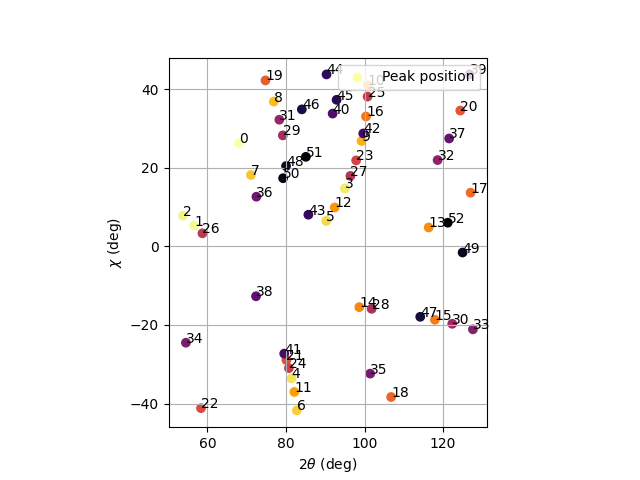

In [26]:
imageindex = 538

filename = os.path.join(corfilefolder,'img_%04d.cor'%imageindex)
from LaueTools.LaueDataResultsPlots import PlotPeakPos
ff, aa = PlotPeakPos(filename, frame='angles',showindex=True)
aa.grid()

In [27]:
corfilefolder

PosixPath('/data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/datfiles_notebook')

## [TEST] on a single .cor file

In [28]:
imageindex = 218

t0 = time.time()
filename = os.path.join(corfilefolder,'img_%04d.cor'%imageindex)

UB547 = np.array([[-0.944920932918629, -0.164116940216228,  0.28227572173489 ],
       [ 0.325197212589104, -0.401535417654801,  0.855019004360563],
       [-0.027816725726933,  0.89905990210913 ,  0.434389207372524]])

previousResults = (2, [UB_2, UB_1], 0, 0)

res = index_refine(filename,
                   ignorefitfileresults=True,
                   usepreviousUB=False,#(1,[UB547],0,0),
                   skipindexing=False,
                   useinternalmultiprocessing=True,
                   writefitfile=False,
                   verboselevel=0)

print('Indexing single dataset (but with multiprocessing acceleration)')
print(f'Initial number of spots {res[0]}')
if res[1][0][1] is not None:
    GT.printgreen(f'UB matrix(ces) found: {res[1]}')
    GT.printgreen(f'Matching rate (grain index, [Nb of indexed spots, MR (%)]): {res[2]}')
else:
    GT.printred(f'UB matrix(ces) found: {res[1]}')
    GT.printred(f'Last Matching rate (grain index, [Nb of indexed spots, MR (%)]): {res[2]}')
print('Info: ', res[-1])
print('Elapsed time: %.2f seconds'%(time.time()-t0))

100%|██████████| 1344/1344 [00:00<00:00, 2855.60it/s]


Indexing single dataset (but with multiprocessing acceleration)
Initial number of spots 218
UB matrix(ces) found: [(0, array([[-0.496826852073101, -0.638273298777973, -0.588555208999875],
       [ 0.848892814668109, -0.497871277128914, -0.176531037918834],
       [-0.180000922484652, -0.587384245192303,  0.788803460478765]]))]
Matching rate (grain index, [Nb of indexed spots, MR (%)]): [(0, [40, 21.62162162162162])]
Info:   Treated by IndexSpotsSet().
Elapsed time: 3.62 seconds


In [29]:
UB218 = np.array([[-0.496826852073101, -0.638273298777973, -0.588555208999875],
       [ 0.848892814668109, -0.497871277128914, -0.176531037918834],
       [-0.180000922484652, -0.587384245192303,  0.788803460478765]])

## MULTIPROCESS INDEX & REFINE  .cor files

In [63]:
if __name__=='__main__':
    #-------------  user-defined parameters ------------------
    nb_cpus = 64
    
    # if True reanalyse all .cor images (whatever existing .fit files...) and overwrite results .fit files
    # if False, only .cor file with missing corresponding fitfile will be analysed
    ignorefitfileresults =True
    
    # if False, indexing from scratch
    # if 'fromfitfile', refinement of UB matrix found in corresponding .fit file. If refinement is poor then indexing from scratch
    # if elements tuple (nb of matrices, list of UB,0,0)
    usepreviousUB = (1,[UB218],0,0)
    
    # inhibit or not indexing from scratch after having tested previous results
    # True if one wants to catch only 1 grain
    # False to allow indexing from scratch
    skipindexing = True

    # generally True to save permanently results on disk with .fit file
    writefitfile = True 
    
    
    #-----------set `listfiles` ----------------------------------
    #cor_filelist = [os.path.join(corfilefolder,_file) for _file in os.listdir(corfilefolder) if (_file.startswith("img_") and _file.endswith(".cor"))]
    
    # use better Path.glob('*.cor') ...
    cor_filelist = [ff for ff in sorted(corfilefolder.glob('img*.cor'))]
    
    # to test or handle only a subset of the list of files by image index
    startindex, finalindex = 0, 0 + 3*nb_cpus
    listindices = np.arange(startindex,finalindex+1,1)
    # final choice of the list of files 
    selectedlistfiles = [ff for ff in cor_filelist if GT.getfileindex(ff) in listindices]

    #   user choice of `listindices`
    listfiles= cor_filelist
    #listfiles = cor_filelist[547:547+2*nb_cpus]
    #listfiles = selectedlistfiles
    
    
    verboselevel = 0
    # ---------------------------------------------------------
    #---------END OF user-defined parameters ------------------
    #----------------------------------------------------------
    
    nb_corfiles = len(listfiles)
    args_index_refine = zip(listfiles,
                   itertools.repeat(ignorefitfileresults),
                   itertools.repeat(usepreviousUB),
                   itertools.repeat(skipindexing),
                            itertools.repeat(False),
                            itertools.repeat(writefitfile),
                           itertools.repeat(verboselevel))

    t4 = time.time()

    with multiprocessing.Pool(nb_cpus) as pool:
        allresults = pool.starmap(index_refine,
                     tqdm(args_index_refine, total = nb_corfiles, desc = 'Indexation and Refinement progress'),
                     chunksize = 1)

    t5 = time.time()
    minutes = int(np.ceil(t5 - t4) // 60)
    seconds = int(np.ceil(t5 - t4)  % 60)

    print(f"It took {minutes}mins and {seconds}s to index {nb_corfiles} images with {nb_cpus} cpus.")
    if not multiprocessing.active_children():
        GT.printgreen("Done!\n\n")

        print('Process and summarize results')
        
        # Results Summary:
        treatedimages = []
        Nbindexedimages2D = np.zeros(mapdims, dtype=int)
        MRindexedimages2D = np.zeros(mapdims, dtype=float)
        maskindexed2D = False*np.ones(mapdims, dtype=bool)
        grainlistindices = []
        nonindexedimages = []
        indexedimages = []
        n2 = mapdims[1]
        
        for elem in tqdm(allresults):
            ix, dictmatrix, dictMR, info = elem
            treatedimages.append(ix)
            #print(dictmatrix)
            if len(dictmatrix)>0:
                maskindexed2D[ix//n2, ix%n2]=True
                grainlistindices.append(ix)
                indexedimages.append(ix)
                nbindexed, MR = dictMR[0][1]
                if isinstance(nbindexed, int):
                    Nbindexedimages2D[ix//n2, ix%n2]=nbindexed
                if isinstance(MR, float):
                    MRindexedimages2D[ix//n2, ix%n2]=MR
            else:
                nonindexedimages.append(ix)
                maskindexed2D[ix//n2, ix%n2]=False
        
        GT.printgreen('Done !')

Indexation and Refinement progress: 100%|██████████| 1651/1651 [00:08<00:00, 198.21it/s]


It took 0mins and 11s to index 1651 images with 64 cpus.
Done!


Process and summarize results


100%|██████████| 1651/1651 [00:00<00:00, 402557.60it/s]

Done !


In [25]:
#allresults[500:520]

### [SAVE] `allresults`

In [73]:
SAVE_ALLRESULTS_PICKLE = True

saving_folder = corfilefolder
mystamp = 'G1'
saving_filename = 'allresults_%s.pickle'%mystamp



#------------end of user inputs -------------
if SAVE_ALLRESULTS_PICKLE: # SAVE
    fullpathsaving = os.path.join(saving_folder,saving_filename)
    
    WRITEFILE=True
    if Path(fullpathsaving).exists():
        GT.printred('The following File already exists!')
        if input('Do you want to overwrite it?') not in ('y','Y','yes','YES'):
            print('Please change the filename if you really want to save your results')
            WRITEFILE=False
            
if WRITEFILE:    
    dict_scan_data = {'maindatafolder':maindatafolder,
                     'subfolderscandata':subfolderscandata,
                     'datfilefolder':datfilefolder,
                     'corfilefolder':corfilefolder,
                     'prefixfilename':prefixfilename,
                     'suffix':suffix,
                     'CCDLabel':CCDLabel,
                     'sizeofzeropadding':sizeofzeropadding,
                     'detfile':detfile,
                     'mapdims':mapdims}
    
    dict_index_refine_for_mpi ={'e_min':e_min,
                      'e_max':e_max,
                      'e_max_MR':e_max_MR,
                      'key_material':key_material,
                      'nbGrainstoFind':nbGrainstoFind,
                      'depth':depth,
                      'dict_indexrefine':dict_indexrefine,
                      'MatchingRate_List':MatchingRate_List,
                      'MIN_NUMBERSPOTS_FOR_INDEXING':MIN_NUMBERSPOTS_FOR_INDEXING,
                      'MAX_NUMBERSPOTS_FOR_INDEXING':MAX_NUMBERSPOTS_FOR_INDEXING}
    
    dict_info_collect_mpi = {'nb_cpus':nb_cpus,
                            'ignorefitfileresults':ignorefitfileresults,
                            'usepreviousUB':usepreviousUB,
                            'skipindexing':skipindexing,
                            'writefitfile':writefitfile}
    
    dict_results_summary = {'treatedimages':treatedimages,
                           'nonindexedimages':nonindexedimages,
                           'indexedimages':indexedimages,
                           'maskindexed2D':maskindexed2D,
                            'Nbindexedimages2D':Nbindexedimages2D,
                            'MRindexedimages2D':MRindexedimages2D,
                            'grainlistindices':grainlistindices}
    
    dictresults={}
    dictresults['allresults']=allresults
    dictresults['dict_scan_data'] = dict_scan_data
    dictresults['dict_index_refine_for_mpi'] = dict_index_refine_for_mpi
    dictresults['dict_results_summary'] = dict_results_summary
    with open(fullpathsaving, 'wb') as f:
        pickle.dump(dictresults, f)
        GT.printgreen(f'\nLast allresults.pickle file was saved at {datetime.datetime.now()}:')
        GT.printgreen(f'{fullpathsaving}')

The following File already exists!


Do you want to overwrite it? y



Last allresults.pickle file was saved at 2025-04-11 19:12:00.790976:
/data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/datfiles_notebook/allresults_G1.pickle


### [LOAD] `allresults` from "allresults" .pickle file

In [63]:
if 0: #LOAD
    fullpathsaving = '/data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/'
    fullpathsaving += 'sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/'
    fullpathsaving += 'datfiles_notebook/allresults_G1.pickle'
    if input('Are you sure to load a previous file and overwrite dictresults?') in ('y','yes','Y','YES','o','O'):
        with open(fullpathsaving, 'rb') as f:
            dictresults=pickle.load(f)
        allresults = dictresults['allresults']
        dict_scan_data = dictresults['dict_scan_data']
        dict_index_refine_for_mpi= dictresults['dict_index_refine_for_mpi']
        dict_results_summary = dictresults['dict_results_summary']
        mapdims = dict_scan_data['mapdims']
        corfilefolder = dict_scan_data['corfilefolder']
        depth = dict_index_refine_for_mpi['depth']
        maskindexed2D = dict_results_summary['maskindexed2D']

## Some visualisations of results (to evaluate quality confidence)

In [35]:
# Results Summary:
treatedimages = []
Nbindexedimages2D = np.zeros(mapdims, dtype=int)
MRindexedimages2D = np.zeros(mapdims, dtype=float)
grainlistindices = []
nonindexedimages = []
indexedimages = []
flagindexed = []
n2 = mapdims[1]

for elem in tqdm(allresults):
    ix, dictmatrix, dictMR, info = elem
    treatedimages.append(ix)
    #print(dictmatrix)
    if len(dictmatrix)>0:
        flagindexed.append(True)
        grainlistindices.append(ix)
        indexedimages.append(ix)
        nbindexed, MR = dictMR[0][1]
        if isinstance(nbindexed, int):
            Nbindexedimages2D[ix//n2, ix%n2]=nbindexed
        if isinstance(MR, float):
            MRindexedimages2D[ix//n2, ix%n2]=MR
    else:
        nonindexedimages.append(ix)
        flagindexed.append(False)

GT.printgreen('Done !')

100%|██████████| 1651/1651 [00:00<00:00, 848730.96it/s]

Done !


In [33]:
if usepreviousUB:
    print('-------For usepreviousUB-------\n', usepreviousUB)
    print('and last tolerance angle %.2f deg\n'%dict_indexrefine["list matching tol angles"][-1])
print('nb of treated datasets :',len(treatedimages))
print('number of non indexed datasets', len(nonindexedimages))
print('number of indexed (or updated) datasets', len(indexedimages))
#print('indexed (or updated) dataset indices list',grainlistindices)

-------For usepreviousUB-------
 (1, [array([[-0.496826852073101, -0.638273298777973, -0.588555208999875],
       [ 0.848892814668109, -0.497871277128914, -0.176531037918834],
       [-0.180000922484652, -0.587384245192303,  0.788803460478765]])], 0, 0)
and last tolerance angle 0.10 deg

nb of treated datasets : 1651
number of non indexed datasets 575
number of indexed (or updated) datasets 1076


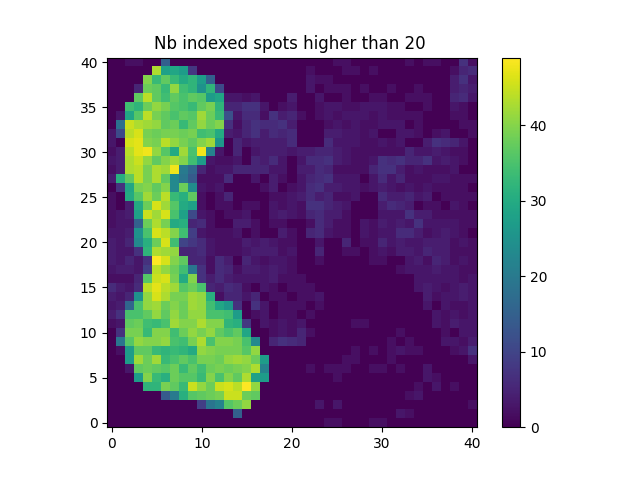

In [49]:
fig2,ax2 = plt.subplots()
Nbindexedimages2Dplot = copy.copy(Nbindexedimages2D)
pp2 = ax2.imshow(Nbindexedimages2Dplot, origin='lower')
ax2.set_title('Nb indexed spots higher than %d '%MinNbthreshold)
plt.colorbar(pp2)
GT.format_getimageindex_imshow.__defaults__=(mapdims,)
ax2.format_coord = GT.format_getimageindex_imshow

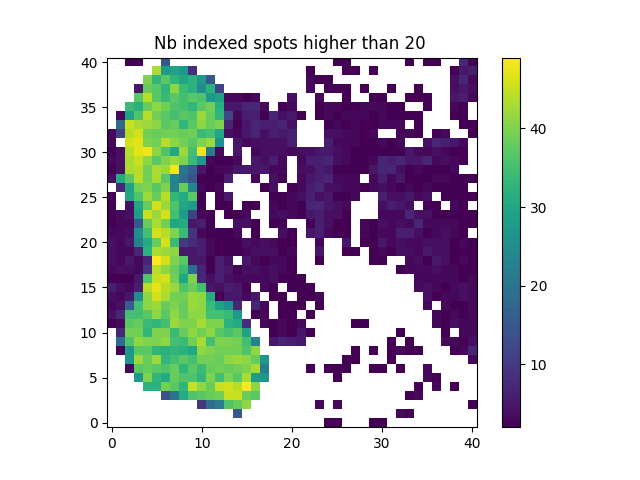

In [58]:
# using mask of indexed and refined data
fig2,ax2 = plt.subplots()
Nbindexedimages2Dplot = copy.copy(Nbindexedimages2D)
Nbindexedimages2Dplot = ma.masked_where(np.invert(maskindexed2D), Nbindexedimages2Dplot)
pp2 = ax2.imshow(Nbindexedimages2Dplot, origin='lower')
ax2.set_title('Nb indexed spots higher than %d '%MinNbthreshold)
plt.colorbar(pp2)
GT.format_getimageindex_imshow.__defaults__=(mapdims,)
ax2.format_coord = GT.format_getimageindex_imshow

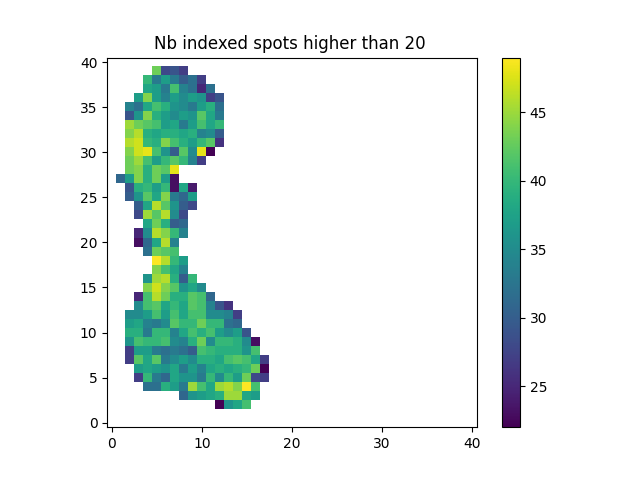

In [52]:
# using mask wrt mininmum number of index spots
MinNbthreshold = 20 # in % unit

import numpy.ma as ma
Nbindexedimages2Dplot = copy.copy(Nbindexedimages2D)
if MinNbthreshold:
    Nbindexedimages2Dplot = ma.masked_where(Nbindexedimages2Dplot <= MinNbthreshold, Nbindexedimages2Dplot)

fig2,ax2 = plt.subplots()
pp2 = ax2.imshow(Nbindexedimages2Dplot, origin='lower')
ax2.set_title('Nb indexed spots higher than %d '%MinNbthreshold)
plt.colorbar(pp2)
GT.format_getimageindex_imshow.__defaults__=(mapdims,)
ax2.format_coord = GT.format_getimageindex_imshow



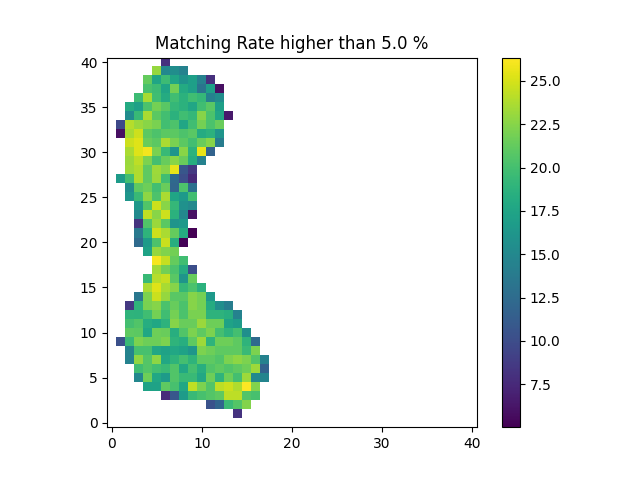

In [53]:
# using mask wrt mininmum number of matching rate (%)
MinMRthreshold = 5 # in %

cond_smallMR = MRindexedimages2Dplot <= MinMRthreshold


fig3,ax3 = plt.subplots()
MRindexedimages2Dplot = copy.copy(MRindexedimages2D)
if MinMRthreshold:
    MRindexedimages2Dplot = ma.masked_where(cond_smallMR, MRindexedimages2Dplot)
    

pp3= ax3.imshow(MRindexedimages2Dplot,origin='lower')
ax3.set_title('Matching Rate higher than %.1f %%'%MinMRthreshold)
cb2 = plt.colorbar(pp3)

GT.format_getimageindex_imshow.__defaults__=(mapdims,)
ax3.format_coord = GT.format_getimageindex_imshow


In [54]:
maskfromMR = ma.masked_where(MRindexedimages2Dplot <= MinMRthreshold,MRindexedimages2Dplot).mask
maskfromMR

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [55]:
ma.masked_array(Nbindexedimages2Dplot)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999)

In [56]:
# True indexed, False non indexed
maskindexed2D

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False,  True, ..., False,  True,  True]])

In [57]:
# True, to be masked, False to be kept
np.invert(maskindexed2D)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ...,  True, False, False]])

# COLLECT .fit files results 

**multiprocessing collection, read .fit files  and  plot results**

In [16]:
import LaueTools.fitfilereader  as fitreader
from LaueTools.fitfilereader import parsed_fitfile, parsed_fitfileseries
from LaueTools.LaueDataResultsPlots import (StrainMap, EulerAngles,EulerAngles2D,
                                            LatticeParamsMap, PlotNumberIndexedSpots,
                                           PlotMeanDevPixel, StrainMapHistogram)

def getimageindex_fromxyech(xech, yech, mapdims, xech_stepsize=1., yech_stepsize = 1., startingindex = 0):
    """get imageindex from relative positions xech and yech  (mapdims =(xech dim, yech dim))"""
    ii = int(xech/xech_stepsize)
    jj = int(yech/yech_stepsize)
    return startingindex + mapdims[1]*jj+ii

In [17]:
ffs0 = parsed_fitfileseries(folderpath=fitfilefolder, nb_cols=mapdims[1], nb_rows=mapdims[0],
                            prefix = 'img_', suffix = '_g0.fit', use_multiprocessing = True)

Using 64 cpus.


Parsing progress:   0%|          | 0/1681 [00:00<?, ?it/s]

Done!


# VISUALIZE

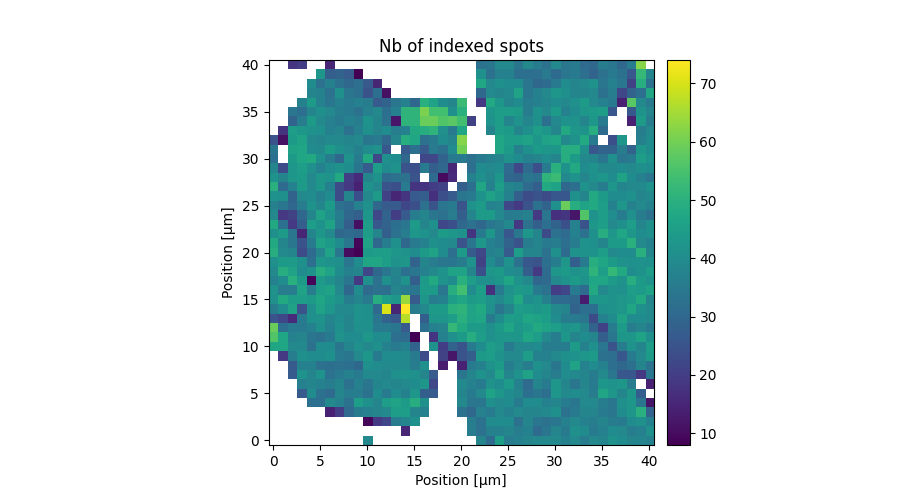

In [18]:
_, ax = PlotNumberIndexedSpots(indexed_fileseries = ffs0 , size = (9,5), origin='lower')

ax.format_coord = lambda x, y: GT.format_getimageindex_imshow(x, y, mapdims)

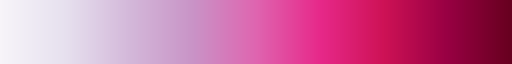

In [19]:
cond_lowNbindexed2D=ffs0.NumberOfIndexedSpots.reshape(mapdims)<5
cond_largepixeldev = ffs0.MeanDevPixel.reshape(mapdims)>.7

combinedconds = np.logical_or(cond_lowNbindexed2D,cond_largepixeldev)
mycmap = mpl.colormaps['PuRd']
mycmap.set_over('yellow')
mycmap.set_bad('black')
mycmap

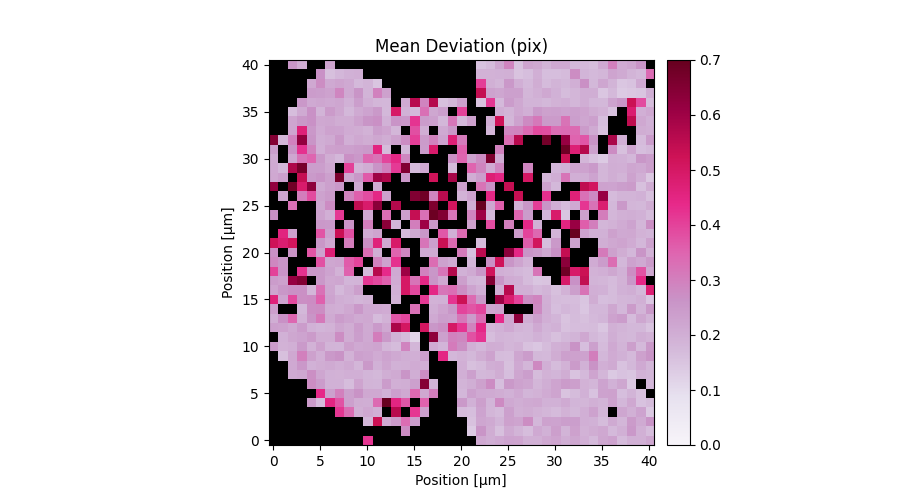

In [20]:
_, ax = PlotMeanDevPixel(indexed_fileseries = ffs0 ,size = (9,5),
                         origin='lower', maskingcondition=combinedconds,
                         norm= mpl.colors.Normalize(vmin=0,vmax=.7),
                        cmap=mycmap)
ax.format_coord = lambda x, y: GT.format_getimageindex_imshow(x, y, mapdims)

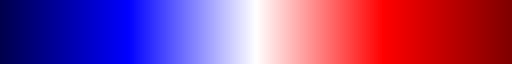

In [21]:
straincmap= mpl.colormaps['seismic']
straincmap.set_over('yellow')
straincmap.set_bad('lightgray')
straincmap.set_under('green')
straincmap

In [22]:
xech_stepsize, yech_stepsize = 1., 1.

# visualisation parameters
maxamplitudestrain = 3  # in 10-4 units
strain_frame = 'sample' # 'crystal'
mask = maskfromMR #None, combinedconds

fig, ax = StrainMap(xech = np.arange(mapdims[1])*xech_stepsize, yech = np.arange(mapdims[0])*yech_stepsize,
                    indexed_fileseries = ffs0 , frame =strain_frame,
                    multiplier = 1e4,
                    scale = 'other', vmin=None, vmax=None,
                    norm= mpl.colors.Normalize(vmin=-maxamplitudestrain,vmax=maxamplitudestrain), # in 10-4 units
                    size = (9,5), cmap=straincmap,
                    maskingcondition=mask)

fig.tight_layout()

NameError: name 'maskfromMR' is not defined

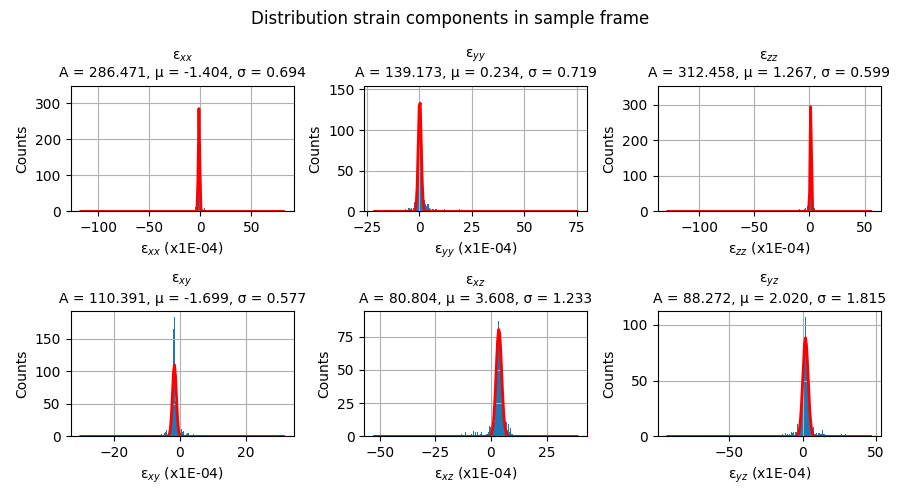

In [49]:

fig, ax, fit_params = StrainMapHistogram(indexed_fileseries = ffs0,
                    multiplier = 1e4, maskingcondition=maskfromMR.ravel(),#combinedconds.ravel(),
                    size = (9,5),  frame='sample', # 'crystal'
                            bins=400, fit=True)
[_ax.grid() for _ax in ax.ravel()]
fig.tight_layout()

In [50]:
fit_params

array([88.27220769697925 ,  2.019818141554244,  1.814894291376685])

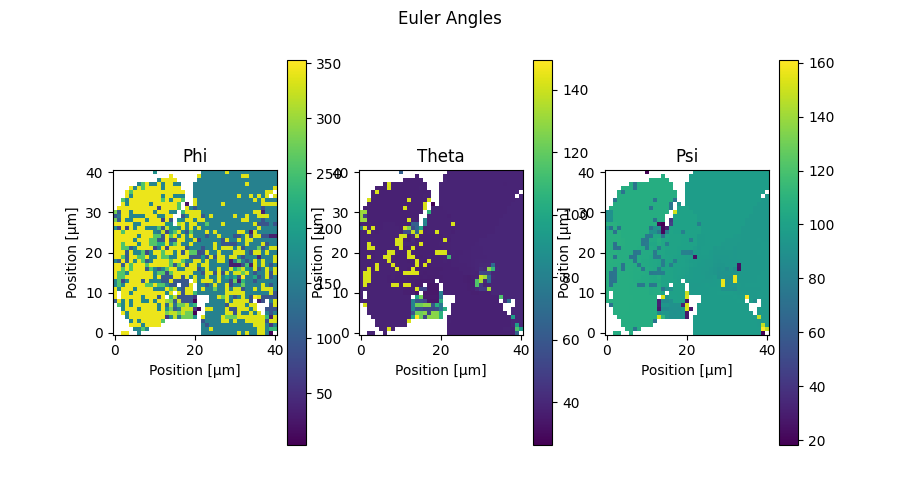

In [90]:
EulerAngles2D(xech = np.arange(mapdims[1])*xech_stepsize, yech = np.arange(mapdims[0])[::-1]*yech_stepsize,
              indexed_fileseries = ffs0 , 
              size = (9,5))

In [161]:
UBs2Dmap = ffs0.UB.reshape((mapdims[0],mapdims[1],3,3))


In [100]:
i_image=getimageindex_fromxyech(33,35, mapdims)
i_image

1468

In [101]:
print(f'For image #{i_image}, Orientation Matrix UB:\n',ffs0.UB[i_image].tolist())
ffile = parsed_fitfile(os.path.join(fitfilefolder,'img_%04d_g0.fit'%i_image), verbose=0)
ffile.UB, ffile.NumberOfIndexedSpots, ffile.MeanDevPixel

For image #1468, Orientation Matrix UB:
 [[0.438461926, 0.660457514, -0.609992356], [-0.860302274, 0.504022456, -0.072757148], [0.259114198, 0.556482051, 0.78869972]]


(array([[ 0.438461926,  0.660457514, -0.609992356],
        [-0.860302274,  0.504022456, -0.072757148],
        [ 0.259114198,  0.556482051,  0.78869972 ]]),
 43,
 0.223)

In [ ]:
# TODO compute kernel average Map

In [113]:
# ref UB matrice
i_ref = 276
UB0 = ffs0.UB[i_ref]

AngleDev = []
for ii in range(mapdims[0]*mapdims[1]):
    AngleDev.append(GT.getRotationAngleFrom2Matrices(np.linalg.qr(UB0)[0], np.linalg.qr(ffs0.UB[ii])[0]))

AngleDev = np.array(AngleDev)

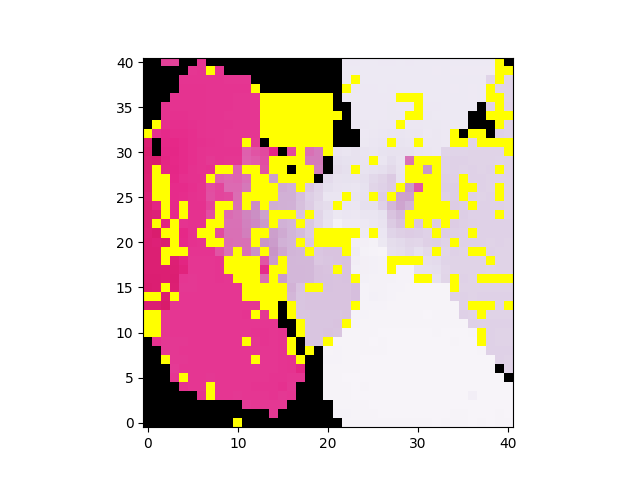

In [117]:
fig, ax = plt.subplots()
ax.imshow(AngleDev.reshape(mapdims), vmin=0, vmax=10., cmap = mycmap, origin='lower')
ax.format_coord = lambda x, y: GT.format_getimageindex_imshow(x, y, mapdims)

In [144]:
class HidePrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
def myPlotPeakPos(filepathdat: str, size: tuple = None, frame:str='pixel', showindex:bool=False, figax=None,  **kwargs) -> tuple:
    with HidePrint():
        peaklist = IOLT.readfile_dat(filepathdat)
        
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
        ax.invert_yaxis()
    if size is not None:
        fig.set_size_inches(size[0], size[1])

    if frame=='pixel':
        x,y = peaklist[:,2:4].T
        xlabel, ylabel = 'pixel X','pixel Y'
    elif frame == 'angles':
        x,y = peaklist[:,:2].T
        xlabel, ylabel = r'2$\theta$',r'$\chi$'
    
    ax.scatter(x,y, label = 'Peak position', cmap = plt.cm.inferno,
                               s=30,
                               c = np.arange(len(x), 0,-1), **kwargs)
    if showindex:
        for _i, (_x, _y) in enumerate(zip(x,y)):
            #ax.annote(x + 1, y + 1, "%d" % _i)
            ax.annotate("%d" % _i, xy=(_x, _y), xycoords='data')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_aspect('equal')
    ax.legend(loc = 'upper right')
    
    return fig, ax

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='2$\\theta$', ylabel='$\\chi$'>)

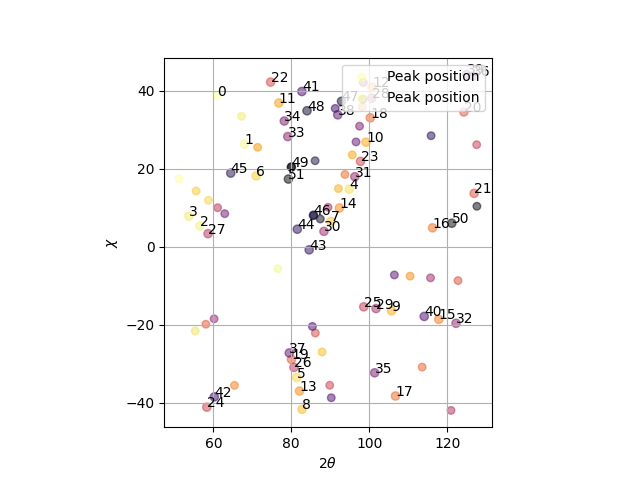

In [149]:
imageindex_1 = 218
imageindex_2 = 226

filename1 = os.path.join(corfilefolder,'img_%04d.cor'%imageindex_1)
filename2 = os.path.join(corfilefolder,'img_%04d.cor'%imageindex_2)
from LaueTools.LaueDataResultsPlots import PlotPeakPos
ff, aa = PlotPeakPos(filename1, frame='angles',showindex=True, alpha=0.5)
aa.grid(True)

myPlotPeakPos(filename2, frame='angles',figax=(ff, aa), alpha=0.5)


# [STUDIES] NUMERICAL AND LAUETOOLS ACCURACY

for a given orientation 

## by sampling the reference structure, we test the refinement convergence

UB orientation matrix is constant

In [113]:
# create N different strcuture with a fixed orientation matrix

c0 = 4.85
mymaterials = {}
for kk in range(10):
    mymaterials['Zn%d'%kk]= ['Zn%d'%kk, [2.6649, 2.6649, c0+0.03*kk, 90, 90, 120], 'wurtzite']
    
mymaterials = {}
a0,b0,c0,alp0, bet0, gam0 = DictLT.dict_Materials['Zn'][1]
N = 20
deltal= np.random.uniform(-.1,.1,size=(N,2))
deltaangles = np.random.uniform(-.1,.1,size=(N,3))
for kk, deltas in enumerate(zip(deltal,deltaangles)):
    da=0
    db, dc = deltas[0]
    dalp, dbet, dgam = deltas[1]
    mymaterials['Zntest%d'%kk]= ['Zntest%d'%kk, [a0+da, b0+db, c0+dc, 90+dalp, 90+dbet, 120+dgam], 'wurtzite']
    
print('\n-------- mymaterials  dict --------------')
print(mymaterials)


-------- mymaterials  dict --------------
{'Zntest0': ['Zntest0', [2.6649, 2.648221922826027, 5.038401655041278, 90.04017308772687, 90.02836865020824, 120.0182116981061], 'wurtzite'], 'Zntest1': ['Zntest1', [2.6649, 2.673946956047671, 5.003194487116708, 89.90115030331074, 89.97914098973702, 120.07512981442005], 'wurtzite'], 'Zntest2': ['Zntest2', [2.6649, 2.731378521670139, 4.973892406330968, 90.06752837997514, 90.04696025597735, 119.93860714373126], 'wurtzite'], 'Zntest3': ['Zntest3', [2.6649, 2.651962890693633, 4.942673643362081, 90.05861497508491, 90.05533939725943, 120.03877222356735], 'wurtzite'], 'Zntest4': ['Zntest4', [2.6649, 2.6168570331123546, 4.961842949002042, 89.97356440407145, 90.07987908341813, 120.04063378065533], 'wurtzite'], 'Zntest5': ['Zntest5', [2.6649, 2.632728269859358, 4.913030722149547, 90.0113068723035, 89.96260762077833, 120.08991904218219], 'wurtzite'], 'Zntest6': ['Zntest6', [2.6649, 2.7285718180021346, 5.021427463684151, 90.05643107581984, 90.040586854558

In [107]:
# General parameters indexation
e_min = 5   # [keV]
e_max = 18  # [keV]  # for indexation only ?? (how to refine with emax larger?)
### -----------arguments of IndexSpotsSet() ------------ ###

# ------------  GuessedUBMatrix ---------------
#Since previousResults is limited to single phase or material.Even better we can test a 

# Index refine parameters
dict_indexrefine = {'AngleTolLUT': 0.2,   # Tolerance angle [deg] to recognise angles in the Angular LUT Database
                    'nlutmax': 5,         # Maximum miller index in the Angular LUT Database
                    # Angular tolerance list for auto links between exp. - theo. spots
                    'list matching tol angles': [1,0.5,0.2,0.1,0.1], 
                    # spots set A:  [0,2,58,34] CAUTION max(A) < NBMAXPROBED
                    'central spots indices': [0,1,2],   
                    #number of most intense spot candidate to have a recognisable distance
                    'NBMAXPROBED': 5, # spots set B alias of [0, ..., NBMAXPROBED-1]
                    'MATCHINGRATE_ANGLE_TOL': 0.5,
                    'MinimumMatchingRate': 0,
                    'MinimumNumberMatches': 20,
                    'UseIntensityWeights': False,
                    'nbSpotsToIndex': 10000, # during refinement max number of pairs exp.-theo. spots
                    'CheckOrientation': None, # os.path.join(working_dir,'UBmat.ubs'),
                    'MATCHINGRATE_THRESHOLD_IAL': 2,
                    'GuessedUBMatrix': previousResults
                    }

# list of minimum matching rates that accept to perform the next refinement step (with less tolerance angle)
# Last term is the final minimum matching rate (in percent) to accept the final refinement.
MatchingRate_List = [2,2,2,2,2,2] 
# len(MatchingRate_List) > len('list matching tol angles')

In [108]:
imageindex = 547
pathfilecor = os.path.join(corfilefolder,'img_%04d.cor'%imageindex)


t0 = time.time()
# (Re)Initialize object spotsset
UBsol = np.array([[-0.946190704006459, -0.165042674567985,  0.280650321594703],
       [ 0.32573740376703 , -0.402236471801761,  0.850366386984638],
       [-0.027936014406621,  0.900811005080669,  0.431842883341892]])
previousResults = (1,[UBsol],0,0)
res=[]
for kk in range(N):
    # missing info from the dictionary filled manually
    key_material = 'Zntest%d'%kk
    
    dataset = ISS.spotsset()

    # Init the dataset with laue spots of .cor file
    dataset.importdatafromfile(pathfilecor)
    dataset.key_material = key_material
    dataset.emin = e_min
    dataset.emax = e_max
    
    dataset.inhibitindexing = True

    # index the current dataset
    dataset.IndexSpotsSet(None,key_material,e_min,e_max,dict_indexrefine,None,
                                  use_file=0, # if 1 , reinit dataset and first argument must be a path to .cor file
                                  IMM=False,
                                  n_LUT = dict_indexrefine['nlutmax'],
                                  LUT = None,
                                  angletol_list = dict_indexrefine['list matching tol angles'],
                                  nbGrainstoFind = 1, 
                                  previousResults = previousResults,
                                  dirnameout_fitfile = fitfilefolder,
                                  corfilename = pathfilecor,
                                  verbose = 0,
                                  MatchingRate_List = MatchingRate_List,
                                dictmaterials = mymaterials,
                                 choose_UB_MinEulerepresentative=False)
    
    pixelresidues = dataset.pixelresidues
    if pixelresidues is None:
        meanpixel= -1
        pixelresidues = []
    else:
        meanpixdev = np.mean(pixelresidues)

    print(f'\n---- Resulst of indexing image #{imageindex} ----')
    print("initial nb of spots",dataset.nbspots)
    print("dict of UB matrix found",dataset.dict_grain_matrix)
    print('dict of nb of indexed spots and matching rate (%):',dataset.dict_grain_matching_rate)
    print('[FOR CHECK] nb of spots for refinements',len(pixelresidues))
    print('Mean pixel residue',meanpixdev) 
    print('elapsed time %.2f sec  with internal multiprocessing of {nbmaxcpus} cpus'%(time.time()-t0))
    if dataset.dict_grain_matrix is {} or any([v is None for v in dataset.dict_grain_matrix.values()]):
        print('Nothing found ')
    res.append([dataset.dict_grain_devstrain, dataset.dict_grain_latticeparameters, dataset.key_material,
                dataset.dict_grain_matching_rate,
                len(pixelresidues), meanpixdev ])
    


---- Resulst of indexing image #547 ----
initial nb of spots 263
dict of UB matrix found {0: array([[-0.946190701613762, -0.168068313488828,  0.278556654905886],
       [ 0.325737409237106, -0.402759326887289,  0.852118259696152],
       [-0.027936031665301,  0.903808298662895,  0.434115694786918]])}
dict of nb of indexed spots and matching rate (%): {0: [39, 79.59183673469387]}
[FOR CHECK] nb of spots for refinements 39
Mean pixel residue 0.4173707921319523
elapsed time 0.56 sec  with internal multiprocessing of {nbmaxcpus} cpus

---- Resulst of indexing image #547 ----
initial nb of spots 263
dict of UB matrix found {0: array([[-0.946190818892504, -0.172591595728399,  0.28194793969599 ],
       [ 0.325737136003383, -0.405438977780668,  0.849443212433933],
       [-0.027935245370279,  0.912033689872707,  0.430111164944401]])}
dict of nb of indexed spots and matching rate (%): {0: [39, 79.59183673469387]}
[FOR CHECK] nb of spots for refinements 39
Mean pixel residue 0.4173976964804477

In [114]:
afinal = []
bfinal = []
cfinal = []
alphafinal = []
betafinal = []
gammafinal = []

latparamsfinal = []
Nindexed_MR = []
Pixdev = []
minPixdev = 100
maxNindexed = 0
for el in res:
    grain_ix = 0
    rr = el[1][grain_ix]
    nbindexed_mr = el[3][grain_ix]
    # by default it s grain 0
    pixdev = el[-1]
    if pixdev<minPixdev:
        minPixdev = pixdev
    if nbindexed_mr[0]>maxNindexed:
        maxNindexed = nbindexed_mr[0]
    
    if rr is not None:
        latparamsfinal.append(rr)
        Nindexed_MR.append(nbindexed_mr)
        Pixdev.append(pixdev)
    
latparamsfinal = np.array(latparamsfinal)
Nindexed_MR = np.array(Nindexed_MR)
Pixdev = np.array(Pixdev)
print('nb of refined solutions', len(latparamsfinal))
print('mean results', np.mean(latparamsfinal, axis=0))
print('std results', np.round(np.std(latparamsfinal, axis=0), decimals=6))
print('max mb indexed spots:',maxNindexed)
print('min pix dev:',minPixdev)
#latparamsfinal,Nindexed_MR

nb of refined solutions 20
mean results [  2.664900000000001   2.669164390259688   4.944128400099986
  89.97842929154642   89.90692471989645  120.0298229331268  ]
std results [0.       0.006317 0.002062 0.141394 0.112348 0.031993]
max mb indexed spots: 39
min pix dev: 0.41735319140376476


In [115]:
# select only solutions with the SAME Nb of indexed spots
latparamsfinal_select = []
for kk,el in enumerate(latparamsfinal):
    if Nindexed_MR[kk][0]==maxNindexed:
        latparamsfinal_select.append(el)
    
latparamsfinal_select=np.array(latparamsfinal_select)

In [130]:
print('on selected refined solutions with %d indexed spots'%maxNindexed)
print('nb of refined solutions', len(latparamsfinal_select))
print('Statistical results\n             a,         b,         c,     alpha,   beta,   gamma')
GT.printgreen(f'mean       {np.round(np.mean(latparamsfinal_select, axis=0), decimals=4)}')
GT.printgreen(f'std results {np.round(np.std(latparamsfinal_select, axis=0), decimals=7)}')
print('max mb indexed spots:',maxNindexed)

on selected refined solutions with 39 indexed spots
nb of refined solutions 15
Statistical results
             a,         b,         c,     alpha,   beta,   gamma
mean       [  2.6649   2.6666   4.9432  90.0369  89.9508 120.0196]
std results [0.00e+00 1.60e-06 7.00e-07 4.80e-06 1.21e-05 2.74e-05]
max mb indexed spots: 39


## by sampling orientation matrix and reference structure lattice parameters, we test the refinement convergence

In [179]:
# General parameters indexation
e_min = 5   # [keV]
e_max = 18  # [keV]  # for indexation only ?? (how to refine with emax larger?)
### -----------arguments of IndexSpotsSet() ------------ ###

# ------------  GuessedUBMatrix ---------------
#Since previousResults is limited to single phase or material.Even better we can test a 

# Index refine parameters
dict_indexrefine = {'AngleTolLUT': 0.2,   # Tolerance angle [deg] to recognise angles in the Angular LUT Database
                    'nlutmax': 5,         # Maximum miller index in the Angular LUT Database
                    # Angular tolerance list for auto links between exp. - theo. spots
                    'list matching tol angles': [1,0.5,0.2,0.1,0.1], 
                    # spots set A:  [0,2,58,34] CAUTION max(A) < NBMAXPROBED
                    'central spots indices': [0,1,2],   
                    #number of most intense spot candidate to have a recognisable distance
                    'NBMAXPROBED': 5, # spots set B alias of [0, ..., NBMAXPROBED-1]
                    'MATCHINGRATE_ANGLE_TOL': 0.5,
                    'MinimumMatchingRate': 0,
                    'MinimumNumberMatches': 20,
                    'UseIntensityWeights': False,
                    'nbSpotsToIndex': 10000, # during refinement max number of pairs exp.-theo. spots
                    'CheckOrientation': None, # os.path.join(working_dir,'UBmat.ubs'),
                    'MATCHINGRATE_THRESHOLD_IAL': 2,
                    'GuessedUBMatrix': previousResults
                    }

# list of minimum matching rates that accept to perform the next refinement step (with less tolerance angle)
# Last term is the final minimum matching rate (in percent) to accept the final refinement.
MatchingRate_List = [2,2,2,2,2,2] 
# len(MatchingRate_List) > len('list matching tol angles')

In [188]:
imageindex = 547
pathfilecor = os.path.join(corfilefolder,'img_%04d.cor'%imageindex)

import random
t0 = time.time()
# (Re)Initialize object spotsset
UBsol = np.array([[-0.946190704006459, -0.165042674567985,  0.280650321594703],
       [ 0.32573740376703 , -0.402236471801761,  0.850366386984638],
       [-0.027936014406621,  0.900811005080669,  0.431842883341892]])

res=[]
# random choice of Zntest
N = 30
for ii in range(N):
    # missing info from the dictionary filled manually
    key_material = random.choice(list(mymaterials.keys()))
    randomaxis = np.random.uniform(-1,1,size=3)
    randomangle = np.random.uniform(-2,2,size=1)
    UBmodified = UBsol.dot(GT.matRot(randomaxis, randomangle))
    previousResults = (1,[UBmodified],0,0)
    
    print(f'\n test {ii}/{N-1} key_material', key_material, f'random angle {randomangle[0]:.2f} deg')
    
    dataset = ISS.spotsset()

    # Init the dataset with laue spots of .cor file
    dataset.importdatafromfile(pathfilecor)
    dataset.key_material = key_material
    dataset.emin = e_min
    dataset.emax = e_max
    
    dataset.inhibitindexing = True

    # index the current dataset
    dataset.IndexSpotsSet(None,key_material,e_min,e_max,dict_indexrefine,None,
                                  use_file=0, # if 1 , reinit dataset and first argument must be a path to .cor file
                                  IMM=False,
                                  n_LUT = dict_indexrefine['nlutmax'],
                                  LUT = None,
                                  angletol_list = dict_indexrefine['list matching tol angles'],
                                  nbGrainstoFind = 1, 
                                  previousResults = previousResults,
                                  dirnameout_fitfile = fitfilefolder,
                                  corfilename = pathfilecor,
                                  verbose = 0,
                                  MatchingRate_List = MatchingRate_List,
                                dictmaterials = mymaterials,
                                 choose_UB_MinEulerepresentative=False)
    
    pixelresidues = dataset.pixelresidues
    if pixelresidues is None:
        meanpixel= -1
        pixelresidues = []
        
    else:
        meanpixdev = np.mean(pixelresidues)
        res.append([dataset.dict_grain_devstrain, dataset.dict_grain_latticeparameters, dataset.key_material,
                dataset.dict_grain_matching_rate,
                len(pixelresidues), meanpixdev ])
        
        if 0:

            print(f'\n---- Resulst of indexing image #{imageindex} ----')
            print("initial nb of spots",dataset.nbspots)
            print("dict of UB matrix found",dataset.dict_grain_matrix)
            print('dict of nb of indexed spots and matching rate (%):',dataset.dict_grain_matching_rate)
            print('[FOR CHECK] nb of spots for refinements',len(pixelresidues))
            print('Mean pixel residue',meanpixdev) 
            print('elapsed time %.2f sec  with internal multiprocessing of {nbmaxcpus} cpus'%(time.time()-t0))
            if dataset.dict_grain_matrix is {} or any([v is None for v in dataset.dict_grain_matrix.values()]):
                print('Nothing found ')
    
    


 test 0/29 key_material Zn7 random angle 1.40 deg

 test 1/29 key_material Zn3 random angle -0.45 deg

 test 2/29 key_material Zn1 random angle 1.29 deg

 test 3/29 key_material Zn9 random angle -1.20 deg

 test 4/29 key_material Zn0 random angle -1.33 deg

 test 5/29 key_material Zn8 random angle -0.64 deg

 test 6/29 key_material Zn7 random angle -0.48 deg

 test 7/29 key_material Zn4 random angle 0.91 deg

 test 8/29 key_material Zn5 random angle -0.96 deg

 test 9/29 key_material Zn7 random angle 0.23 deg

 test 10/29 key_material Zn5 random angle -0.43 deg

 test 11/29 key_material Zn7 random angle -1.61 deg

 test 12/29 key_material Zn4 random angle 0.08 deg

 test 13/29 key_material Zn5 random angle -0.11 deg

 test 14/29 key_material Zn1 random angle -0.92 deg

 test 15/29 key_material Zn2 random angle -1.17 deg

 test 16/29 key_material Zn9 random angle -0.08 deg

 test 17/29 key_material Zn5 random angle -1.26 deg

 test 18/29 key_material Zn5 random angle -0.98 deg

 test 1

In [189]:
afinal = []
bfinal = []
cfinal = []
alphafinal = []
betafinal = []
gammafinal = []

latparamsfinal = []
Nindexed_MR = []
Pixdev = []
minPixdev = 100
maxNindexed = 0
for el in res:
    grain_ix = 0
    rr = el[1][grain_ix]
    nbindexed_mr = el[3][grain_ix]
    # by default it s grain 0
    pixdev = el[-1]
    if pixdev<minPixdev:
        minPixdev = pixdev
    if nbindexed_mr[0]>maxNindexed:
        maxNindexed = nbindexed_mr[0]
    
    if rr is not None:
        latparamsfinal.append(rr)
        Nindexed_MR.append(nbindexed_mr)
        Pixdev.append(pixdev)
    
latparamsfinal = np.array(latparamsfinal)
Nindexed_MR = np.array(Nindexed_MR)
Pixdev = np.array(Pixdev)
print('nb of refined solutions', len(latparamsfinal))
print('mean results', np.mean(latparamsfinal, axis=0))
print('std results', np.round(np.std(latparamsfinal, axis=0), decimals=6))
print('max mb indexed spots:',maxNindexed)
print('min pix dev:',minPixdev)
#latparamsfinal,Nindexed_MR

nb of refined solutions 23
mean results [  2.664900000000001   2.662584162009829   4.945929793811429
  89.90058288430478   89.85035513147663  119.98614416511973 ]
std results [0.       0.021904 0.020026 0.304077 0.225204 0.152203]
max mb indexed spots: 39
min pix dev: 0.37943940898085027


In [190]:
# select only solutions with the SAME Nb of indexed spots
latparamsfinal_select = []
for kk,el in enumerate(latparamsfinal):
    if Nindexed_MR[kk][0]==maxNindexed:
        latparamsfinal_select.append(el)
    
latparamsfinal_select=np.array(latparamsfinal_select)

In [191]:
print('on selected refined solutions with %d indexed spots'%maxNindexed)
print('nb of refined solutions', len(latparamsfinal_select))
print('Statistical results\n             a,         b,         c,     alpha,   beta,   gamma')
GT.printgreen(f'mean       {np.round(np.mean(latparamsfinal_select, axis=0), decimals=4)}')
GT.printgreen(f'std results {np.round(np.std(latparamsfinal_select, axis=0), decimals=7)}')
print('max mb indexed spots:',maxNindexed)

on selected refined solutions with 39 indexed spots
nb of refined solutions 16
Statistical results
             a,         b,         c,     alpha,   beta,   gamma
mean       [  2.6649   2.6666   4.9432  90.0369  89.9508 120.0196]
std results [0.000e+00 5.400e-06 1.400e-06 1.510e-05 1.260e-05 1.048e-04]
max mb indexed spots: 39


## TODO:   simulate laue pattern for any orientation matrix, and test refinement resolution by sampling initial UB and structure

In [229]:
nbUBs=1
key_material_0 = 'Zn'
emax = 22
simulfolder = corfilefolder # d['folder']
N= 20

import LaueTools.CrystalParameters as CP
import LaueTools.lauecore as LC
from scipy.spatial.transform import Rotation as R

Rs = R.random(nbUBs,random_state=1234)
quatlist = Rs.as_quat()
UBlist = Rs.as_matrix()


detectorparameters = [79.000,975.00,941.00,0,0]

pixelsize = 0.0734
framedim = (2018,2016)

CCDCalibdict = {'dd': detectorparameters[0],
            'xcen': detectorparameters[1],
            'ycen': detectorparameters[2], 'xbet': detectorparameters[3],
            'xgam': detectorparameters[4], 'xpixelsize': pixelsize, 'ypixelsize': pixelsize,
            'CCDLabel': 'sCMOS', 'framedim': framedim, 'detectordiameter': 165,
            'kf_direction': 'Z>0', 'pixelsize': pixelsize}



l_tth, l_chi, l_miller_ind, l_posx, l_posy, l_E = [],[],[],[],[],[]

k=0
Quats=[]
nbspots=np.zeros(len(quatlist))
listnbspots = [0]
res=[]



Rs = R.random(N,random_state=1234)
quatlist = Rs.as_quat()
UBlist = Rs.as_matrix()

# General parameters indexation
e_min = 5   # [keV]
e_max = emax  # [keV]  # for indexation only ?? (how to refine with emax larger?)
### -----------arguments of IndexSpotsSet() ------------ ###

# ------------  GuessedUBMatrix ---------------
#Since previousResults is limited to single phase or material.Even better we can test a 

# Index refine parameters
dict_indexrefine = {'AngleTolLUT': 0.2,   # Tolerance angle [deg] to recognise angles in the Angular LUT Database
                    'nlutmax': 5,         # Maximum miller index in the Angular LUT Database
                    # Angular tolerance list for auto links between exp. - theo. spots
                    'list matching tol angles': [1,0.5,0.2,0.1,0.1], 
                    # spots set A:  [0,2,58,34] CAUTION max(A) < NBMAXPROBED
                    'central spots indices': [0,1,2],   
                    #number of most intense spot candidate to have a recognisable distance
                    'NBMAXPROBED': 5, # spots set B alias of [0, ..., NBMAXPROBED-1]
                    'MATCHINGRATE_ANGLE_TOL': 0.5,
                    'MinimumMatchingRate': 0,
                    'MinimumNumberMatches': 20,
                    'UseIntensityWeights': False,
                    'nbSpotsToIndex': 10000, # during refinement max number of pairs exp.-theo. spots
                    'CheckOrientation': None, # os.path.join(working_dir,'UBmat.ubs'),
                    'MATCHINGRATE_THRESHOLD_IAL': 2,
                    'GuessedUBMatrix': previousResults
                    }

# list of minimum matching rates that accept to perform the next refinement step (with less tolerance angle)
# Last term is the final minimum matching rate (in percent) to accept the final refinement.
MatchingRate_List = [2,2,2,2,2,2] 
# len(MatchingRate_List) > len('list matching tol angles')

for ii in range(N):
    UBmatrix =UBlist[ii]
    grain = CP.Prepare_Grain(key_material_0, UBmatrix)

    s_tth, s_chi, s_miller_ind, s_posx, s_posy, s_E= LC.SimulateLaue_full_np(grain, 5,emax,detectorparameters,
                                                                             pixelsize=pixelsize,detectordiameter=300,
                                                                             dim=framedim,
                                                                            removeharmonics=1)
    

    corfilename = IOLT.writefile_cor('temp_simul', s_tth, s_chi, s_posx, s_posy, s_E,
                       param=CCDCalibdict, overwrite=1, dirname_output=simulfolder)
    pathfilecor= os.path.join(simulfolder,corfilename)

    
    # missing info from the dictionary filled manually
    key_material = random.choice(list(mymaterials.keys()))
    randomaxis = np.random.uniform(-1,1,size=3)
    randomangle = np.random.uniform(-.5,.5,size=1)
    UBmodified = UBmatrix.dot(GT.matRot(randomaxis, randomangle))
    previousResults = (1,[UBmodified],0,0)
    
    print(f'\n test {ii}/{N-1} key_material', key_material, f'random angle {randomangle[0]:.2f} deg')
    
    dataset = ISS.spotsset()

    # Init the dataset with laue spots of .cor file
    dataset.CCDLabel='sCMOS'
    dataset.importdatafromfile(pathfilecor)
    
    dataset.key_material = key_material
    dataset.emin = e_min
    dataset.emax = e_max
    
    dataset.inhibitindexing = True

    # index the current dataset
    dataset.IndexSpotsSet(None,key_material,e_min,e_max,dict_indexrefine,None,
                                  use_file=0, # if 1 , reinit dataset and first argument must be a path to .cor file
                                  IMM=False,
                                  n_LUT = dict_indexrefine['nlutmax'],
                                  LUT = None,
                                  angletol_list = dict_indexrefine['list matching tol angles'],
                                  nbGrainstoFind = 1, 
                                  previousResults = previousResults,
                                  dirnameout_fitfile = fitfilefolder,
                                  corfilename = pathfilecor,
                                  verbose = 0,
                                  MatchingRate_List = MatchingRate_List,
                                dictmaterials = mymaterials,
                                 choose_UB_MinEulerepresentative=False)
    
    pixelresidues = dataset.pixelresidues
    if pixelresidues is None:
        meanpixel= -1
        pixelresidues = []
        
    else:
        meanpixdev = np.mean(pixelresidues)
        res.append([dataset.dict_grain_devstrain, dataset.dict_grain_latticeparameters, dataset.key_material,
                dataset.dict_grain_matching_rate,
                len(pixelresidues), meanpixdev ])
        
        if 0:

            print(f'\n---- Resulst of indexing image #{imageindex} ----')
            print("initial nb of spots",dataset.nbspots)
            print("dict of UB matrix found",dataset.dict_grain_matrix)
            print('dict of nb of indexed spots and matching rate (%):',dataset.dict_grain_matching_rate)
            print('[FOR CHECK] nb of spots for refinements',len(pixelresidues))
            print('Mean pixel residue',meanpixdev) 
            print('elapsed time %.2f sec  with internal multiprocessing of {nbmaxcpus} cpus'%(time.time()-t0))
            if dataset.dict_grain_matrix is {} or any([v is None for v in dataset.dict_grain_matrix.values()]):
                print('Nothing found ')
    
    


 test 0/19 key_material Zn8 random angle 0.10 deg
there is no missing reflections for grain 0

 test 1/19 key_material Zn4 random angle -0.22 deg
there is no missing reflections for grain 0

 test 2/19 key_material Zn8 random angle 0.09 deg
there is no missing reflections for grain 0

 test 3/19 key_material Zn6 random angle 0.29 deg
there is no missing reflections for grain 0

 test 4/19 key_material Zn1 random angle 0.14 deg
there is no missing reflections for grain 0

 test 5/19 key_material Zn7 random angle 0.42 deg
there is no missing reflections for grain 0

 test 6/19 key_material Zn5 random angle -0.22 deg
there is no missing reflections for grain 0

 test 7/19 key_material Zn9 random angle -0.40 deg
there is no missing reflections for grain 0

 test 8/19 key_material Zn2 random angle -0.20 deg
there is no missing reflections for grain 0

 test 9/19 key_material Zn1 random angle -0.08 deg
there is no missing reflections for grain 0

 test 10/19 key_material Zn7 random angle -0

In [230]:
UBlist#res

array([[[-0.831181209358765, -0.059892922646741,  0.552766347587959],
        [-0.532517270623484, -0.200134822078997, -0.822418025993548],
        [ 0.15988481383989 , -0.977936036153817,  0.134454287752916]],

       [[-0.245490408599531, -0.075198229446476, -0.96647797987008 ],
        [-0.968369994354747, -0.02690220730568 ,  0.248064155563575],
        [-0.044654376258356,  0.996805646818976, -0.06621547516087 ]],

       [[-0.731693900181987, -0.320585565827306, -0.601538802921024],
        [ 0.301392547142792,  0.639380428824078, -0.707357900757119],
        [ 0.611380870622604, -0.698868773247113, -0.371208659404416]],

       [[-0.644008076835624, -0.754499490980678, -0.126428300156168],
        [-0.755053905513884,  0.600292775798993,  0.263708519186943],
        [-0.123073948253523,  0.265290598087149, -0.956281183453827]],

       [[ 0.166032670901154,  0.985294840822939,  0.040338924640199],
        [-0.878405497846537,  0.129182689007453,  0.460125650462763],
        [ 0.

In [231]:
afinal = []
bfinal = []
cfinal = []
alphafinal = []
betafinal = []
gammafinal = []

latparamsfinal = []
Nindexed_MR = []
Pixdev = []
minPixdev = 100
maxNindexed = 0
for el in res:
    grain_ix = 0
    rr = el[1][grain_ix]
    nbindexed_mr = el[3][grain_ix]
    # by default it s grain 0
    pixdev = el[-1]
    if pixdev<minPixdev:
        minPixdev = pixdev
    if nbindexed_mr[0]>maxNindexed:
        maxNindexed = nbindexed_mr[0]
    
    if rr is not None:
        latparamsfinal.append(rr)
        Nindexed_MR.append(nbindexed_mr)
        Pixdev.append(pixdev)
    
latparamsfinal = np.array(latparamsfinal)
Nindexed_MR = np.array(Nindexed_MR)
Pixdev = np.array(Pixdev)
print('nb of refined solutions', len(latparamsfinal))
print('mean results', np.mean(latparamsfinal, axis=0))
print('std results', np.round(np.std(latparamsfinal, axis=0), decimals=6))
print('max mb indexed spots:',maxNindexed)
print('min pix dev:',minPixdev)
#latparamsfinal,Nindexed_MR

nb of refined solutions 20
mean results [  2.664900000000001   2.664900017413254   4.946800051361738
  89.9999998052015    90.00000032458556  120.00000023714725 ]
std results [0.e+00 0.e+00 0.e+00 1.e-06 1.e-06 1.e-06]
max mb indexed spots: 122
min pix dev: 3.727279797870313e-06


In [232]:
# select only solutions with the SAME Nb of indexed spots
latparamsfinal_select = []
for kk,el in enumerate(latparamsfinal):
    if Nindexed_MR[kk][0]>0.8*maxNindexed:
        latparamsfinal_select.append(el)
    
latparamsfinal_select=np.array(latparamsfinal_select)

In [233]:
print('on selected refined solutions with %d indexed spots'%maxNindexed)
print('nb of refined solutions', len(latparamsfinal_select))
print('Statistical results\n             a,         b,         c,     alpha,   beta,   gamma')
GT.printgreen(f'mean       {np.round(np.mean(latparamsfinal_select, axis=0), decimals=4)}')
GT.printgreen(f'std results {np.round(np.std(latparamsfinal_select, axis=0), decimals=7)}')
print('max mb indexed spots:',maxNindexed)

on selected refined solutions with 122 indexed spots
nb of refined solutions 20
Statistical results
             a,         b,         c,     alpha,   beta,   gamma
mean       [  2.6649   2.6649   4.9468  90.      90.     120.    ]
std results [0.e+00 0.e+00 1.e-07 9.e-07 6.e-07 1.e-06]
max mb indexed spots: 122
